In [271]:
!pip install yellowbrick

You should consider upgrading via the 'c:\users\chris\anaconda3\python.exe -m pip install --upgrade pip' command.


In [272]:
# Clustering_The_Final_Solution

In [273]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.cm as cm
import seaborn as sns
import scipy.cluster.hierarchy as sch
import sklearn.utils

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from sklearn.model_selection import GridSearchCV
from yellowbrick.cluster import KElbowVisualizer

%matplotlib inline
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [ ]:
#Loading and checking the data
input_data = pd.read_csv("Wholesale customers data.csv")
print(input_data.shape)
initial_data=pd.read_csv("Wholesale customers data.csv")
initial_data

# Initial data analysis and preproccessing

In [275]:
#Identifying the region and channel columns/features
#We have to identify and map which values from the region column correspond to Other Region, Lisbon, Porto respectively 
#and also which values from the Channel column map to Horeca or Retail
#we have the needed info within the data_info.txt where the number of instance for each one is identified 
values_region = [1, 2, 3]

values_channel=[1,2]
print("-------------Region---------------")
for value in values_region:
    count_x = input_data[input_data["Region"] == value].shape[0]
    print("Number of instances where value", value, "appears in the column:", count_x)
print("-------------Channel---------------")    
for value in values_channel:
    count_x = input_data[input_data["Channel"] == value].shape[0]
    print("Number of instances where value", value, "appears in the column:", count_x)
#Based on the data_info.txt
#we can identify that Region=1=> Lisbon, 2=>Porto, 3=>Other region
#and Channel=1=>Horeca, 2=>Retail

-------------Region---------------
Number of instances where value 1 appears in the column: 77
Number of instances where value 2 appears in the column: 47
Number of instances where value 3 appears in the column: 316
-------------Channel---------------
Number of instances where value 1 appears in the column: 298
Number of instances where value 2 appears in the column: 142


In [276]:
#Checking for duplicates
input_data=input_data.drop_duplicates()
print(input_data.shape)
#no duplicates have been identified since the shape remains the same
missing_values = input_data.isnull().sum()
print(missing_values)
#no missing values have been detected

(440, 8)
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


In [277]:
#now we need to replace these in order to perform OHE later on

input_data["Region"] = input_data["Region"].replace({1: "Lisbon", 2: "Porto", 3: "Other Region"})
input_data["Channel"] = input_data["Channel"].replace({1: "Horeca", 2: "Retail"})
print(input_data["Region"].value_counts())
print(input_data["Channel"].value_counts())

input_data

Other Region    316
Lisbon           77
Porto            47
Name: Region, dtype: int64
Horeca    298
Retail    142
Name: Channel, dtype: int64


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,Retail,Other Region,12669,9656,7561,214,2674,1338
1,Retail,Other Region,7057,9810,9568,1762,3293,1776
2,Retail,Other Region,6353,8808,7684,2405,3516,7844
3,Horeca,Other Region,13265,1196,4221,6404,507,1788
4,Retail,Other Region,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,Horeca,Other Region,29703,12051,16027,13135,182,2204
436,Horeca,Other Region,39228,1431,764,4510,93,2346
437,Retail,Other Region,14531,15488,30243,437,14841,1867
438,Horeca,Other Region,10290,1981,2232,1038,168,2125


In [278]:
#Initial analysis of the data
#we have a set of 440 data no null values no duplicates
#The dataset concern 440 buing instances, 
#we can consider these as different people or customers and we will try to analyze their behavor
input_data.describe()



,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


# EDA and Data Description

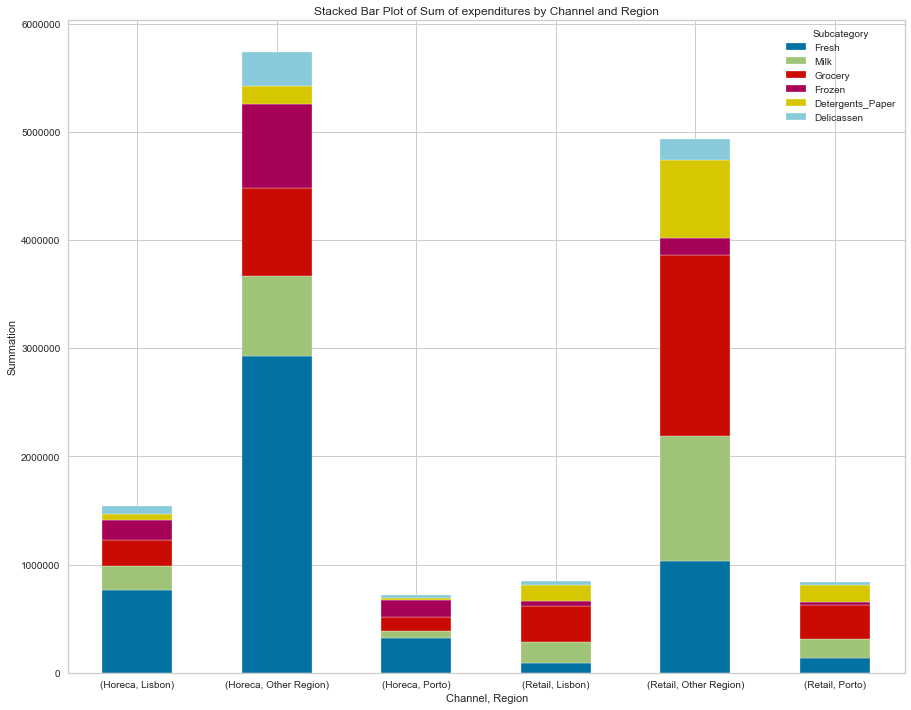

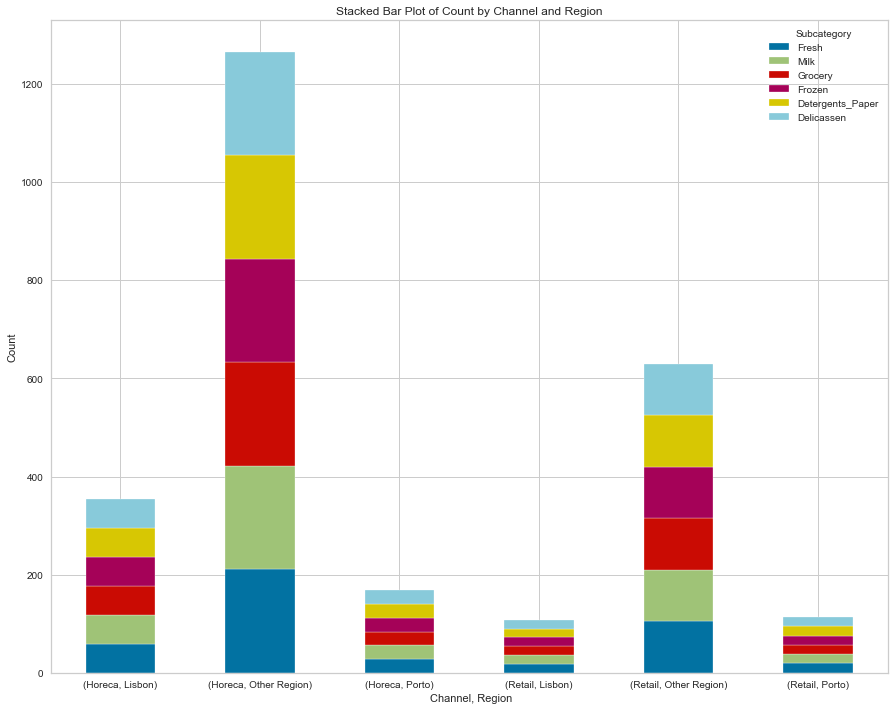

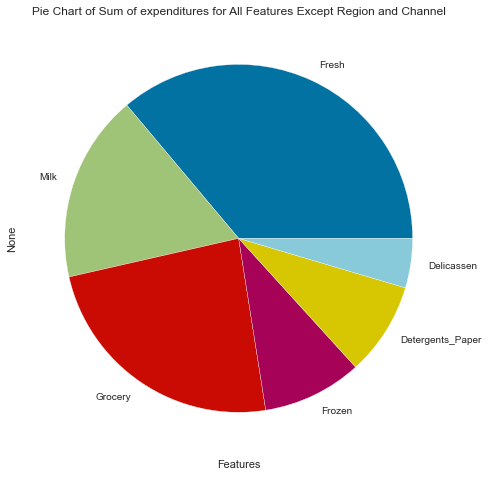

In [279]:
#GROUP BY AND DATA INSIGHTS
#groupby
groupData=input_data.groupby(["Channel", "Region"])
groupChannel=input_data.groupby("Channel")
groupRegion=input_data.groupby("Region")
groupChannel.sum()
#groupRegion.sum()
#initial_data.sum()

# Set labels and title
myplt=groupData.sum().plot(kind='bar', stacked=True, figsize=(15, 12))
plt.xlabel(' Channel, Region')
plt.ylabel('Summation')
plt.title('Stacked Bar Plot of Sum of expenditures by Channel and Region')
plt.legend(title='Subcategory', loc='upper right')
myplt.get_yaxis().get_major_formatter().set_scientific(False)#remove e power notation
plt.xticks(rotation=0)
plt.show()


groupData.count().plot(kind='bar', stacked=True, figsize=(15, 12))
plt.xlabel(' Channel, Region')
plt.ylabel('Count')
plt.title('Stacked Bar Plot of Count by Channel and Region')
plt.legend(title='Subcategory', loc='upper right')
plt.xticks(rotation=0)
plt.show()

sum_except_region_channel = initial_data.drop(columns=['Channel', 'Region']).sum()

# Plotting
plt.figure(figsize=(10,8))
sum_except_region_channel.plot(kind='pie')

# Set labels and title
plt.xlabel('Features')
plt.title('Pie Chart of Sum of expenditures for All Features Except Region and Channel')

plt.xticks(rotation=45)
plt.show()


#we see that the total amount spend and the Count is for Region where =Other Region
#This is to be expected since we also noticed the overrepresentation of Other region compared to Lisbon and POrto
#WE also see that this applies for both channels 
# however we see a differne in the sum (total amount spend in each region/channel) compared to the count
# The 1,3 pairs while DOuble the amount regarding the instances/count compared to 2,3 (Horeca and Other Region , Horeca and Other region)
#The summation has very smaller differences (meaning that probably in Other Regions the items are more expensive)
#MOreover, while the count of all items are of equal propotion the price is difference
#In the case of Heoreca the MIlk product is that of the highest value and on the Retail channel the highest itam seems to be Grocery
#The above is also by the pie chart below
# the 3 most prominent categories regarding their price are in order 1. Fresh 2. Groceries 3. Milk

# Adding columns -enriching the dataset

In [280]:
# a first step is to have an aggragation of the spendings for each one of the instances or customers

input_data['sum_of_expenditures'] = input_data[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].sum(axis=1)

# Display the updated DataFrame
(input_data)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,sum_of_expenditures
0,Retail,Other Region,12669,9656,7561,214,2674,1338,34112
1,Retail,Other Region,7057,9810,9568,1762,3293,1776,33266
2,Retail,Other Region,6353,8808,7684,2405,3516,7844,36610
3,Horeca,Other Region,13265,1196,4221,6404,507,1788,27381
4,Retail,Other Region,22615,5410,7198,3915,1777,5185,46100
...,...,...,...,...,...,...,...,...,...
435,Horeca,Other Region,29703,12051,16027,13135,182,2204,73302
436,Horeca,Other Region,39228,1431,764,4510,93,2346,48372
437,Retail,Other Region,14531,15488,30243,437,14841,1867,77407
438,Horeca,Other Region,10290,1981,2232,1038,168,2125,17834


In [281]:
# we can also add one more columns that can be derived by seperating broadly in two categories the features besides (Channel and region)
#we wll consider as one group the grocery+frozen+Fresh+Milk_Delicatesen => place this into a column called sum_of_food
#we will not include Detergent
input_data['sum_of_food'] = input_data[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Delicassen']].sum(axis=1)

# Display the updated DataFrame
(input_data)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,sum_of_expenditures,sum_of_food
0,Retail,Other Region,12669,9656,7561,214,2674,1338,34112,31438
1,Retail,Other Region,7057,9810,9568,1762,3293,1776,33266,29973
2,Retail,Other Region,6353,8808,7684,2405,3516,7844,36610,33094
3,Horeca,Other Region,13265,1196,4221,6404,507,1788,27381,26874
4,Retail,Other Region,22615,5410,7198,3915,1777,5185,46100,44323
...,...,...,...,...,...,...,...,...,...,...
435,Horeca,Other Region,29703,12051,16027,13135,182,2204,73302,73120
436,Horeca,Other Region,39228,1431,764,4510,93,2346,48372,48279
437,Retail,Other Region,14531,15488,30243,437,14841,1867,77407,62566
438,Horeca,Other Region,10290,1981,2232,1038,168,2125,17834,17666


# EDA second round

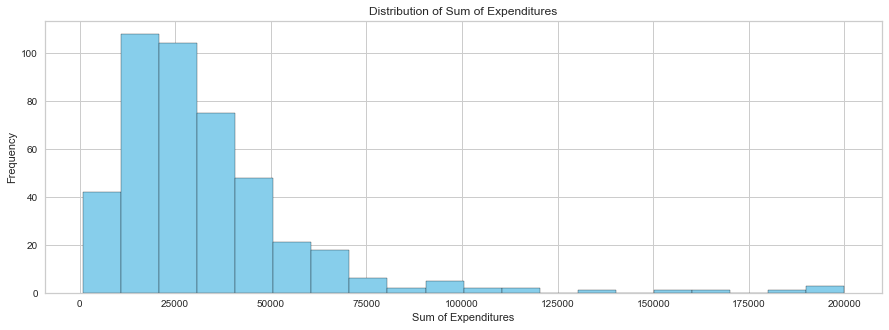

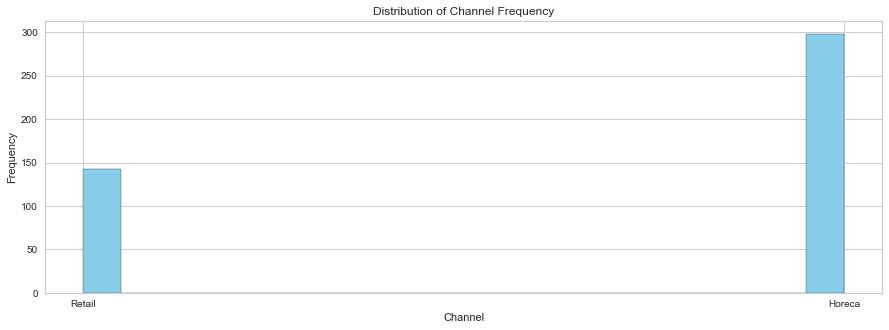

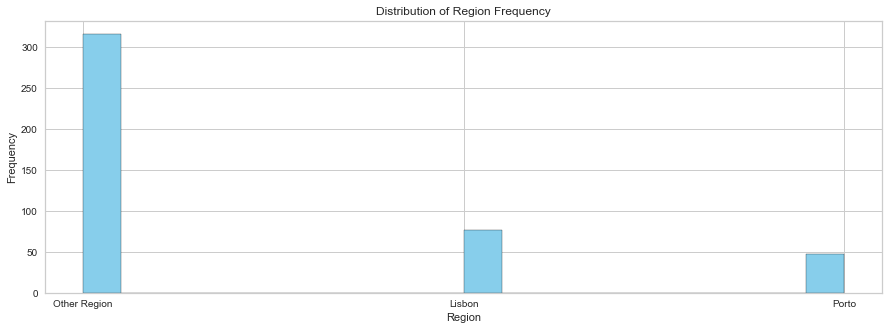

In [282]:
#we can now investigate the results
plt.figure(figsize=(15,5))
plt.hist(input_data['sum_of_expenditures'], bins=20, color='skyblue', edgecolor='black')
# Adding labels and title
plt.xlabel('Sum of Expenditures')
plt.ylabel('Frequency')
plt.title('Distribution of Sum of Expenditures')
#showing the plot
plt.show()


#For frequency
plt.figure(figsize=(15,5))
plt.hist(input_data['Channel'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.title('Distribution of Channel Frequency')
plt.show()
#For region
plt.figure(figsize=(15,5))
plt.hist(input_data['Region'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Region')
plt.ylabel('Frequency')
plt.title('Distribution of Region Frequency')
plt.show()
#We see a great difference between the Region mainly our customers are lpcated in rural areas (not Porto and Lisbon)
# moreover we see that most people tend to buy from Horeca and not from retail

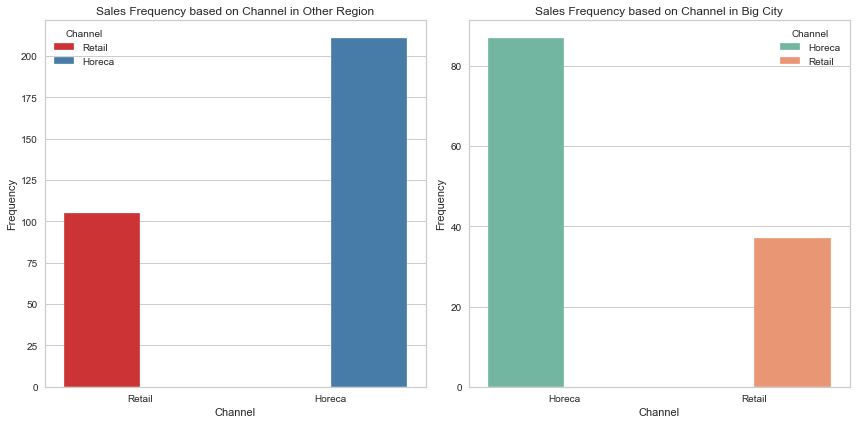

In [283]:
#based also on the above we can identify which is the highest pair wise
plt.figure(figsize=(12, 6))

# Countplot for 'Horeca' in 'Other Region'
plt.subplot(1, 2, 1)
sns.countplot(x="Channel", data=input_data[input_data['Region'] == 'Other Region'], hue='Channel', palette='Set1')
plt.title('Sales Frequency based on Channel in Other Region')
plt.xlabel('Channel')
plt.ylabel('Frequency')

# Countplot for 'Retail' in 'Big City' (Porto and Lisbon)
plt.subplot(1, 2, 2)
sns.countplot(x="Channel", data=input_data[(input_data['Region'] == 'Lisbon') | (input_data['Region'] == 'Porto')], hue='Channel', palette='Set2')
plt.title('Sales Frequency based on Channel in Big City')
plt.xlabel('Channel')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

# we see tha in both cases the people that buy from 

# Investingation Scalling issues

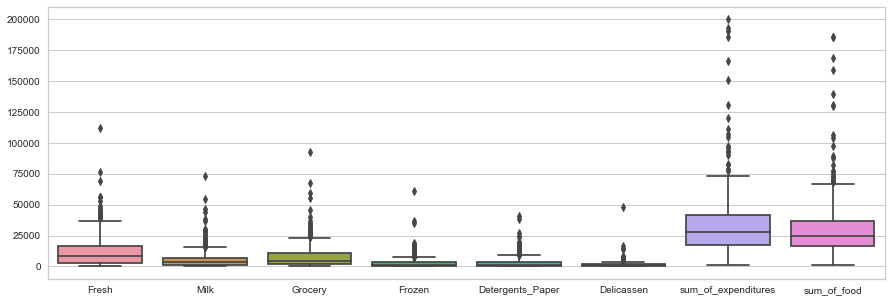

In [284]:
#In order to proceed with the preprocessing we will check for the scaling 
numerical_columns = input_data.select_dtypes(include=['int64', 'float64', 'int32']).columns
plt.figure(figsize=(15,5))
ax = sns.boxplot(data=input_data[numerical_columns])
plt.show();


In [285]:
# we see some discrepances on the scale of data and as such we should proceed with scaling the data.
#as such we will proceed with scaling but first we need to apply one hot encoding to remove the categorical values

#One Hot Encoding (OHE)
#This will allow us to use any clustering algorithm we like
#moreover, dealing with nominal variables, where there is no inherent order among categories, is best to use OHE

input_data_ohe = input_data[['Channel', 'Region']]
input_data_ohe = pd.get_dummies(input_data_ohe, dtype=int)

input_data = input_data.drop(['Channel', 'Region'], axis = 1)
input_data = input_data.join(input_data_ohe)

print(input_data.dtypes)
print(input_data.shape)
input_data

Fresh                  int64
Milk                   int64
Grocery                int64
Frozen                 int64
Detergents_Paper       int64
Delicassen             int64
sum_of_expenditures    int64
sum_of_food            int64
Channel_Horeca         int32
Channel_Retail         int32
Region_Lisbon          int32
Region_Other Region    int32
Region_Porto           int32
dtype: object
(440, 13)


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,sum_of_expenditures,sum_of_food,Channel_Horeca,Channel_Retail,Region_Lisbon,Region_Other Region,Region_Porto
0,12669,9656,7561,214,2674,1338,34112,31438,0,1,0,1,0
1,7057,9810,9568,1762,3293,1776,33266,29973,0,1,0,1,0
2,6353,8808,7684,2405,3516,7844,36610,33094,0,1,0,1,0
3,13265,1196,4221,6404,507,1788,27381,26874,1,0,0,1,0
4,22615,5410,7198,3915,1777,5185,46100,44323,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204,73302,73120,1,0,0,1,0
436,39228,1431,764,4510,93,2346,48372,48279,1,0,0,1,0
437,14531,15488,30243,437,14841,1867,77407,62566,0,1,0,1,0
438,10290,1981,2232,1038,168,2125,17834,17666,1,0,0,1,0


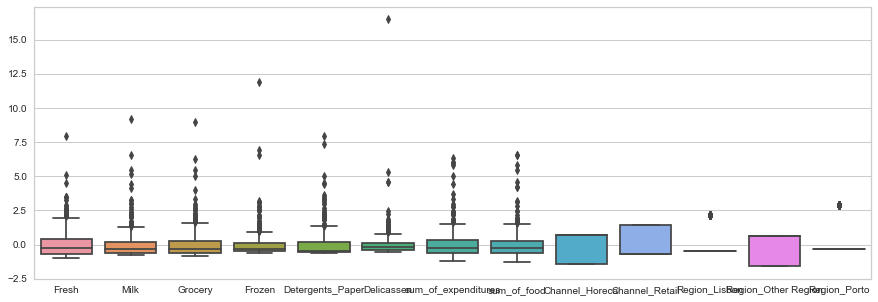

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,sum_of_expenditures,sum_of_food,Channel_Horeca,Channel_Retail,Region_Lisbon,Region_Other Region,Region_Porto
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339,0.033649,0.046335,-1.448652,1.448652,-0.460566,0.626422,-0.345822
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151,0.001514,-0.015750,-1.448652,1.448652,-0.460566,0.626422,-0.345822
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293,0.128535,0.116514,-1.448652,1.448652,-0.460566,0.626422,-0.345822
3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411,-0.222026,-0.147081,0.690297,-0.690297,-0.460566,0.626422,-0.345822
4,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347,0.489011,0.592384,-1.448652,1.448652,-0.460566,0.626422,-0.345822
...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,1.401312,0.848446,0.850760,2.075222,-0.566831,0.241091,1.522273,1.812763,0.690297,-0.690297,-0.460566,0.626422,-0.345822
436,2.155293,-0.592142,-0.757165,0.296561,-0.585519,0.291501,0.575312,0.760034,0.690297,-0.690297,-0.460566,0.626422,-0.345822
437,0.200326,1.314671,2.348386,-0.543380,2.511218,0.121456,1.678200,1.365498,-1.448652,1.448652,-0.460566,0.626422,-0.345822
438,-0.135384,-0.517536,-0.602514,-0.419441,-0.569770,0.213046,-0.584667,-0.537304,0.690297,-0.690297,-0.460566,0.626422,-0.345822


In [286]:
# There is no need to train/test split here prior to scaling since we are not making any predictions using associated labels 
# we proceed using the standardScaler()
numerical_columns = input_data.select_dtypes(include=['int64', 'float64', 'int32']).columns
scaler   = StandardScaler()
scaled_input_data = pd.DataFrame(scaler.fit_transform(input_data[numerical_columns]), columns=input_data[numerical_columns].columns)
plt.figure(figsize=(15,5))
ax = sns.boxplot(data=scaled_input_data)
plt.show();
scaled_input_data

In [287]:
#We now see that our data set is scaled
#reviewing new data_set
scaled_input_data

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,sum_of_expenditures,sum_of_food,Channel_Horeca,Channel_Retail,Region_Lisbon,Region_Other Region,Region_Porto
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339,0.033649,0.046335,-1.448652,1.448652,-0.460566,0.626422,-0.345822
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151,0.001514,-0.015750,-1.448652,1.448652,-0.460566,0.626422,-0.345822
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293,0.128535,0.116514,-1.448652,1.448652,-0.460566,0.626422,-0.345822
3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411,-0.222026,-0.147081,0.690297,-0.690297,-0.460566,0.626422,-0.345822
4,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347,0.489011,0.592384,-1.448652,1.448652,-0.460566,0.626422,-0.345822
...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,1.401312,0.848446,0.850760,2.075222,-0.566831,0.241091,1.522273,1.812763,0.690297,-0.690297,-0.460566,0.626422,-0.345822
436,2.155293,-0.592142,-0.757165,0.296561,-0.585519,0.291501,0.575312,0.760034,0.690297,-0.690297,-0.460566,0.626422,-0.345822
437,0.200326,1.314671,2.348386,-0.543380,2.511218,0.121456,1.678200,1.365498,-1.448652,1.448652,-0.460566,0.626422,-0.345822
438,-0.135384,-0.517536,-0.602514,-0.419441,-0.569770,0.213046,-0.584667,-0.537304,0.690297,-0.690297,-0.460566,0.626422,-0.345822


In [288]:
scaled_input_data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,sum_of_expenditures,sum_of_food,Channel_Horeca,Channel_Retail,Region_Lisbon,Region_Other Region,Region_Porto
count,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02
mean,-2.422305e-17,-1.589638e-17,-6.030530e-17,1.135455e-17,-1.917658e-17,-8.276208e-17,9.386431e-17,1.185920e-16,2.452584e-16,-2.452584e-16,9.525209e-16,8.498253e-16,1.284326e-16
std,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00
min,-9.496831e-01,-7.787951e-01,-8.373344e-01,-6.283430e-01,-6.044165e-01,-5.402644e-01,-1.227749e+00,-1.247952e+00,-1.448652e+00,-6.902971e-01,-4.605662e-01,-1.596367e+00,-3.458220e-01
25%,-7.023339e-01,-5.783063e-01,-6.108364e-01,-4.804306e-01,-5.511349e-01,-3.964005e-01,-5.993005e-01,-5.878089e-01,-1.448652e+00,-6.902971e-01,-4.605662e-01,-1.596367e+00,-3.458220e-01
50%,-2.767602e-01,-2.942580e-01,-3.366684e-01,-3.188045e-01,-4.336004e-01,-1.985766e-01,-2.178099e-01,-2.306732e-01,6.902971e-01,-6.902971e-01,-4.605662e-01,6.264224e-01,-3.458220e-01
75%,3.905226e-01,1.890921e-01,2.849105e-01,9.946441e-02,2.184822e-01,1.048598e-01,3.069688e-01,2.743217e-01,6.902971e-01,1.448652e+00,-4.605662e-01,6.264224e-01,-3.458220e-01
max,7.927738e+00,9.183650e+00,8.936528e+00,1.191900e+01,7.967672e+00,1.647845e+01,6.330728e+00,6.572905e+00,6.902971e-01,1.448652e+00,2.171241e+00,6.264224e-01,2.891661e+00


In [289]:
# Now we are done with the initial preprocessing
# we will start running clustering algorithms
#we are going to work with 
#1. Kmeans
#2. AgglomerativeClustering
#3. DBSCAN

#we will also then apply PCA and use that to run again the same models to see differences

# Working with clustering algorithms -Optimal K

In [290]:
#FOR KMEANS
# we will apply the elbow rule
# and we will also find the silhouette coefficient in order to validate.
#ALL OF THE ABOVE WILL BE PERFORMED ON THE SCALED_input_data

#initializing a pd to hold the rwesults of our runs
final_results = pd.DataFrame([])

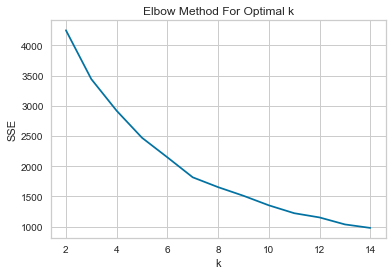

In [291]:
#ELbow Rule
# We will create an empty list for sum of squared distances to be appended for k values 2 to 15
Sum_of_squared_distances = [] 

# Values for K (centroids) 
K = range(2, 15)

for k in K:
    km = KMeans(n_clusters =k, random_state=123)
    km = km.fit(scaled_input_data)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()



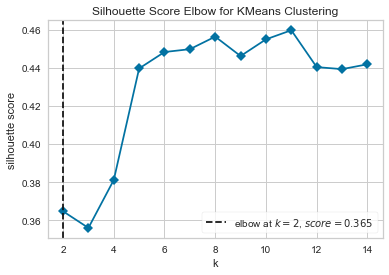

In [292]:
# based on the above we could say that the elbow is formed in both k=5 and k=7
#to validate this we will find the silouhette coefficient as well
model = KMeans(random_state=123) 

visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette', timings=False)
visualizer.fit(scaled_input_data)    
visualizer.poof()
plt.show();
#the silhouette score shows the line at 2, neveertheless asensible k=5 is shown a higher score of ~0.44

# Applying PCA

          PC1       PC2       PC3       PC4       PC5       PC6
0    1.041586 -1.228494 -1.010618 -0.016948  0.167348 -1.228817
1    1.148801 -1.334335 -0.962797  0.020039  0.592151 -0.954102
2    1.563434 -0.556628 -0.970214  0.065699  2.096748 -1.069322
3   -1.030662  0.999477 -0.782241  0.123379  0.178419  0.171731
4    1.553160  0.194343 -0.965904  0.188799  0.756596 -1.906899
..        ...       ...       ...       ...       ...       ...
435  1.769822  3.108744 -0.541540  0.169563 -0.432646  0.258282
436 -0.270975  2.371076 -0.840371  0.078080 -1.111064 -0.822530
437  4.482935 -1.248676 -0.730491 -0.330418 -0.773928  0.501767
438 -1.491373  0.293537 -0.901453 -0.071128  0.167718  0.316729
439 -2.032154 -0.539187 -0.915654 -0.109419  0.019152  0.627479

[440 rows x 6 columns]
       cum_var    exp_var
PC1  37.967209  37.967209
PC2  57.978994  20.011785
PC3  72.265029  14.286035
PC4  81.273920   9.008891
PC5  87.635050   6.361130
PC6  93.173452   5.538402


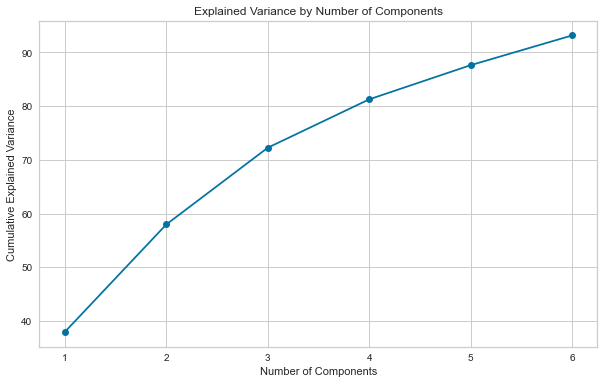

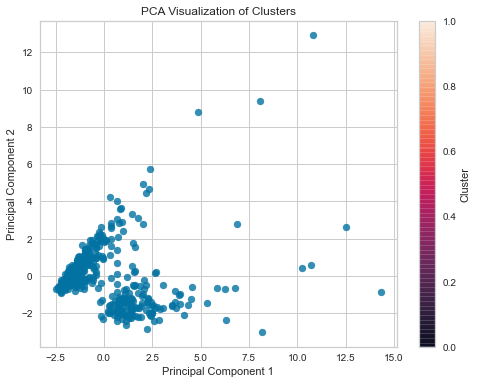

,PC1,PC2,PC3,PC4,PC5,PC6
0,1.041586,-1.228494,-1.010618,-0.016948,0.167348,-1.228817
1,1.148801,-1.334335,-0.962797,0.020039,0.592151,-0.954102
2,1.563434,-0.556628,-0.970214,0.065699,2.096748,-1.069322
3,-1.030662,0.999477,-0.782241,0.123379,0.178419,0.171731
4,1.553160,0.194343,-0.965904,0.188799,0.756596,-1.906899
...,...,...,...,...,...,...
435,1.769822,3.108744,-0.541540,0.169563,-0.432646,0.258282
436,-0.270975,2.371076,-0.840371,0.078080,-1.111064,-0.822530
437,4.482935,-1.248676,-0.730491,-0.330418,-0.773928,0.501767
438,-1.491373,0.293537,-0.901453,-0.071128,0.167718,0.316729


In [293]:
#since we have few features we are going to work with 6 principal components 
#this number also explains (cumulatively) a ~93% which is a good chechpoint for our data
pca = PCA(n_components=6)
PCs = ['PC'+str(i+1) for i in range(6)]
pca_data = pca.fit_transform(scaled_input_data)
pca_data = pd.DataFrame(pca_data, columns = PCs) 
 

explained_variance = pca.explained_variance_ratio_*100
cum_var = np.cumsum(pca.explained_variance_ratio_*100)

# Printing the cumulative and explained variance  for each Principal Component
pca_var = pd.DataFrame(data={'cum_var': cum_var,  "exp_var":explained_variance}, index=PCs)
pca_var

print(pca_data)
print(pca_var)

# Visualize the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cum_var, marker='o', linestyle='-')
plt.title('Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Create a scatter plot of the PCA-transformed data
plt.figure(figsize=(8, 6))
plt.scatter(pca_data["PC1"], pca_data["PC2"],  cmap='viridis', alpha=0.8)
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()
pca_data

In [294]:
# we see that the silouhette score is highlighted elbow is =2 this is not the best case scenario since we would like to have as k an even number
#ideally aligning with the k derived from the elbow rule
#But we also see that for k=5 which is a reasonable number for k silouhette score is ~0.44

#We can derive from the above the k=5 is the optimal k for us

#we will create the KMeans  model
#we will also create the AgglomerativeClustering 
#We will finally create the DBSCAN 

# Running the models and retrieving metrics and results

# For Non PCA, Scaled and Preproccessed Data

KMeans Results:
    k Init Method  Max Iter  N Init         WCSS  Silhouette Score  \
71  5      random       300      15  2470.652581          0.439733   
64  5      random       100      10  2470.652581          0.439733   
55  5   k-means++       100      10  2470.652581          0.439733   
56  5   k-means++       100      15  2470.652581          0.439733   
59  5   k-means++       200      15  2470.652581          0.439733   
.. ..         ...       ...     ...          ...               ...   
23  3   k-means++       200      15  3443.194082          0.355978   
22  3   k-means++       200      10  3443.194082          0.355978   
31  3      random       200      10  3443.194082          0.355978   
20  3   k-means++       100      15  3443.194082          0.355978   
21  3   k-means++       200       5  3443.194082          0.355978   

    Davies-Bouldin Index  Calinski-Harabasz Index  
71              0.991974               143.025585  
64              0.991974               

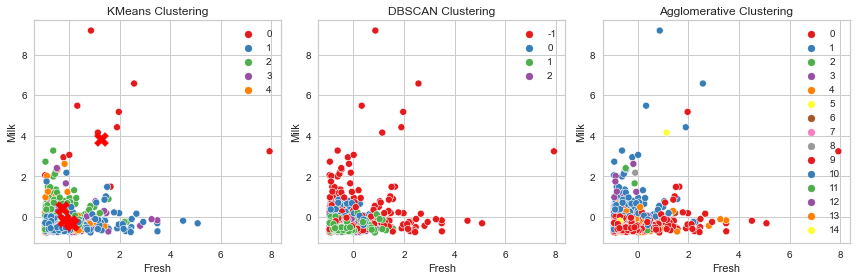

-------------Top Results for Scaled Data (NO PCA)-------------


k Init Method Max Iter N Init     WCSS Silhouette Score  \
KMeans        71  5      random      300     15  2470.65         0.439733   
              64  5      random      100     10  2470.65         0.439733   
              55  5   k-means++      100     10  2470.65         0.439733   
DBSCAN        0   -           -        -      -        -                -   
              1   -           -        -      -        -                -   
              4   -           -        -      -        -                -   
Agglomerative 11  -           -        -      -        -                -   
              1   -           -        -      -        -                -   
              3   -           -        -      -        -                -   

                  Davies-Bouldin Index  Calinski-Harabasz Index  Eps  \
KMeans        71              0.991974               143.025585    -   
              64              0.991974               143.025585    -   
              55              0.991974               143.025585    -   
DBSCAN        0               1.356641                19.450481  0.5   
              1               1.379913                29.452737  0.5   
              4               1.518440                70.712430    1   
Agglomerative 11              0.146326                35.708048    -   
              1               0.146326                35.708048    -   
              3               0.146326                35.708048    -   

                 Min Samples n_clusters   Linkage Distance Metric  
KMeans        71           -          -         -               -  
              64           -          -         -               -  
              55           -          -         -               -  
DBSCAN        0            5          -         -               -  
              1           10          -         -               -  
              4           10          -         -               -  
Agglomerative 11           -          2    single       euclidean  
              1            -          2  complete       euclidean  
              3            -          2  complete              l2

In [295]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize variables to store labels
kmeans_labels = None
dbscan_labels = None
agglomerative_labels = None

# Sample input data 

# Detailed analysis for Kmeans-DBSCAN-Agglomerative
#We run through loops holding and displaying a set of metrics for clustering as they have been identified through research
#We present below the results in a common Dataframe holding the TOP-3 Best results based on specific metrics identified after research
#This happens for each 
#DBI should be Lower
#C-H should be higher

k_values = range(2, 6)


# Initialize lists to store results
results_kmeans = []
results_dbscan = []
results_agglomerative = []

# For KMeans
for k in k_values:
    for init_method in ['k-means++', 'random']:
        for max_iter in [100, 200, 300]:
            for n_init in [5, 10, 15]:
                kmeans = KMeans(n_clusters=k, init=init_method, max_iter=max_iter, n_init=n_init, random_state=1)
                kmeans.fit(scaled_input_data)
                
                # Compute our clustering metrics
                wcss = kmeans.inertia_
                silhouette_avg = silhouette_score(scaled_input_data, kmeans.labels_)
                davies_bouldin = davies_bouldin_score(scaled_input_data, kmeans.labels_)
                calinski_harabasz = calinski_harabasz_score(scaled_input_data, kmeans.labels_)
                
                # Store the labels
                kmeans_labels = kmeans.labels_
                
                # Append results to list
                results_kmeans.append([k, init_method, max_iter, n_init, wcss, silhouette_avg, davies_bouldin, calinski_harabasz])

# Create a DataFrame for KMeans results
results_df_kmeans = pd.DataFrame(results_kmeans, columns=['k', 'Init Method', 'Max Iter', 'N Init', 'WCSS', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

# Sort the KMeans results by silhouette score
results_df_kmeans = results_df_kmeans.sort_values(by=['Silhouette Score'], ascending=False)

print("KMeans Results:")
print(results_df_kmeans)
top_kmeans_results = results_df_kmeans.head(3)

# DBSCAN
#parameters for DBSCAN
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 15]

# Initialize lists to store DBSCAN results
results_dbscan = []

# Iterate over each combination of parameters for DBSCAN
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(scaled_input_data)
        
        unique_labels = np.unique(dbscan.labels_)
        if len(unique_labels) == 1 and unique_labels[0] == -1:
            print(f"No clusters found for eps={eps}, min_samples={min_samples}. Next Please :)")
            continue
        # Silhouette score is not applicable for DBSCAN
        davies_bouldin = davies_bouldin_score(scaled_input_data, dbscan.labels_)
        calinski_harabasz = calinski_harabasz_score(scaled_input_data, dbscan.labels_)
        
        # Store the labels
        dbscan_labels = dbscan.labels_
        
        # Append results to list
        results_dbscan.append([eps, min_samples, davies_bouldin, calinski_harabasz])

# Create a DataFrame for DBSCAN results
results_df_dbscan = pd.DataFrame(results_dbscan, columns=['Eps', 'Min Samples', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

# Sort the DBSCAN results by Davies-Bouldin Index
results_df_dbscan = results_df_dbscan.sort_values(by=['Davies-Bouldin Index'])

print("\nDBSCAN Results:")
print(results_df_dbscan)

top_dbscan_results = results_df_dbscan.sort_values(by=['Davies-Bouldin Index']).head(3)

# Agglomerative Clustering
# Set parameters for Agglomerative Clustering
n_clusters_values = range(2, 16)
linkage_methods = ['ward', 'complete', 'average', 'single']
distance_metrics = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']

# Initialize lists to store Agglomerative Clustering results
results_agglomerative = []

# Iterate over each value of n_clusters, linkage, and distance metric for Agglomerative Clustering
for n_clusters in n_clusters_values:
    for linkage_method in linkage_methods:
        for distance_metric in distance_metrics:
            if linkage_method == 'ward' and distance_metric != 'euclidean':
                continue  # we skip this combination since it is not possible to be applied
                
            agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method, affinity=distance_metric)
            agglomerative.fit(scaled_input_data)
            
            # Silhouette score is not applicable for Agglomerative Clustering
            davies_bouldin = davies_bouldin_score(scaled_input_data, agglomerative.labels_)
            calinski_harabasz = calinski_harabasz_score(scaled_input_data, agglomerative.labels_)
            
            # Store the labels
            agglomerative_labels = agglomerative.labels_
            
            # Append results to list
            results_agglomerative.append([n_clusters, linkage_method, distance_metric, davies_bouldin, calinski_harabasz])

# Create a DataFrame for Agglomerative Clustering results
results_df_agglomerative = pd.DataFrame(results_agglomerative, columns=['n_clusters', 'Linkage', 'Distance Metric', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

# Sort the Agglomerative Clustering results by Davies-Bouldin Index
results_df_agglomerative = results_df_agglomerative.sort_values(by=['Davies-Bouldin Index'])

print("\nAgglomerative Clustering Results:")
print(results_df_agglomerative)

top_agglomerative_results = results_df_agglomerative.sort_values(by=['Davies-Bouldin Index']).head(3)

# Combine the top results for each algorithm into a single DataFrame
top_results = pd.concat([top_kmeans_results, top_dbscan_results, top_agglomerative_results], keys=['KMeans', 'DBSCAN', 'Agglomerative'])



# Plotting KMeans clusters(For first two features)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(x=scaled_input_data['Fresh'], y=scaled_input_data['Milk'], hue=kmeans_labels, palette='Set1', legend=True)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='red', s=200)
plt.title('KMeans Clustering')

# Plotting DBSCAN clusters (For first two features)
plt.subplot(1, 3, 2)
sns.scatterplot(x=scaled_input_data['Fresh'], y=scaled_input_data['Milk'], hue=dbscan_labels, palette='Set1', legend=True)
plt.title('DBSCAN Clustering')

# Plotting Agglomerative Clustering (For first two features)
plt.subplot(1, 3, 3)
sns.scatterplot(x=scaled_input_data['Fresh'], y=scaled_input_data['Milk'], hue=agglomerative_labels, palette='Set1', legend=True)
plt.title('Agglomerative Clustering')

plt.tight_layout()
plt.show()

top_results.fillna('-', inplace=True)
print("-------------Top Results for Scaled Data (NO PCA)-------------")
top_results

# For  PCA Scaled and Preproccessed Data

KMeans Results:
    k Init Method  Max Iter  N Init         WCSS  Silhouette Score  \
71  5      random       300      15  2091.290297          0.477535   
62  5   k-means++       300      15  2091.290297          0.477535   
54  5   k-means++       100       5  2091.290297          0.477535   
56  5   k-means++       100      15  2091.290297          0.477535   
57  5   k-means++       200       5  2091.290297          0.477535   
.. ..         ...       ...     ...          ...               ...   
32  3      random       200      15  3054.020728          0.381533   
33  3      random       300       5  3054.020728          0.381533   
42  4   k-means++       300       5  2660.357153          0.329321   
39  4   k-means++       200       5  2660.357153          0.329321   
36  4   k-means++       100       5  2660.357153          0.329321   

    Davies-Bouldin Index  Calinski-Harabasz Index  
71              0.903571               168.392519  
62              0.903571               

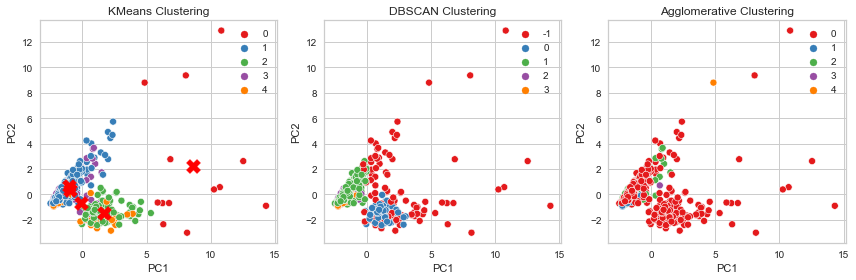

-------------Top Results for Scaled Data PCA Applied-------------


k Init Method Max Iter N Init     WCSS Silhouette Score  \
KMeans        71  5      random      300     15  2091.29         0.477535   
              62  5   k-means++      300     15  2091.29         0.477535   
              54  5   k-means++      100      5  2091.29         0.477535   
DBSCAN        3   -           -        -      -        -                -   
              0   -           -        -      -        -                -   
              5   -           -        -      -        -                -   
Agglomerative 12  -           -        -      -        -                -   
              14  -           -        -      -        -                -   
              13  -           -        -      -        -                -   

                  Davies-Bouldin Index  Calinski-Harabasz Index  Eps  \
KMeans        71              0.903571               168.392519    -   
              62              0.903571               168.392519    -   
              54              0.903571               168.392519    -   
DBSCAN        3               1.249386                76.863443    1   
              0               1.381212                33.423204  0.5   
              5               1.405676                93.672295    1   
Agglomerative 12              0.145252                36.450451    -   
              14              0.145252                36.450451    -   
              13              0.145252                36.450451    -   

                 Min Samples n_clusters Linkage Distance Metric  
KMeans        71           -          -       -               -  
              62           -          -       -               -  
              54           -          -       -               -  
DBSCAN        3            5          -       -               -  
              0            5          -       -               -  
              5           15          -       -               -  
Agglomerative 12           -          2  single              l1  
              14           -          2  single       manhattan  
              13           -          2  single              l2

In [296]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize variables to store labels
kmeans_labels_pca = None
dbscan_labels_pca = None
agglomerative_labels_pca = None

# Detailed analysis for Kmeans-DBSCAN-Agglomerative
#We run through loops holding and displaying a set of metrics for clustering as they have been identified through research
#We present 

#We do ths for the PCA Data
k_values = range(2, 6)
#DBI should be Lower
#C-H should be higher

# Initialize lists to store results
results_kmeans = []
results_dbscan = []
results_agglomerative = []

#  PCA Data


for k in k_values:
    for init_method in ['k-means++', 'random']:
        for max_iter in [100, 200, 300]:
            for n_init in [5, 10, 15]:
                kmeans = KMeans(n_clusters=k, init=init_method, max_iter=max_iter, n_init=n_init, random_state=1)
                kmeans.fit(pca_data)
                
                # Compute various clustering metrics
                wcss = kmeans.inertia_
                silhouette_avg = silhouette_score(pca_data, kmeans.labels_)
                davies_bouldin = davies_bouldin_score(pca_data, kmeans.labels_)
                calinski_harabasz = calinski_harabasz_score(pca_data, kmeans.labels_)
                
                kmeans_labels_pca = kmeans.labels_

                # Append results to list
                results_kmeans.append([k, init_method, max_iter, n_init, wcss, silhouette_avg, davies_bouldin, calinski_harabasz])

# Create a DataFrame for KMeans results
results_df_kmeans = pd.DataFrame(results_kmeans, columns=['k', 'Init Method', 'Max Iter', 'N Init', 'WCSS', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

# Sort the KMeans results by silhouette score
results_df_kmeans = results_df_kmeans.sort_values(by=['Silhouette Score'], ascending=False)

print("KMeans Results:")
print(results_df_kmeans)
top_kmeans_results = results_df_kmeans.head(3)

# DBSCAN
#parameters for DBSCAN
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 15]

# Sample PCA Data
# Assuming pca_data is defined earlier

# Iterate over each combination of parameters for DBSCAN
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(pca_data)
        
        unique_labels = np.unique(dbscan.labels_)
        if len(unique_labels) == 1 and unique_labels[0] == -1:
            print(f"No clusters found for eps={eps}, min_samples={min_samples}. Next Please :)")
            continue
        # Silhouette score is not applicable for DBSCAN
        davies_bouldin = davies_bouldin_score(pca_data, dbscan.labels_)
        calinski_harabasz = calinski_harabasz_score(pca_data, dbscan.labels_)
        
        dbscan_labels_pca = dbscan.labels_
        # Append results to list
        results_dbscan.append([eps, min_samples, davies_bouldin, calinski_harabasz])

# Create a DataFrame for DBSCAN results
results_df_dbscan = pd.DataFrame(results_dbscan, columns=['Eps', 'Min Samples', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

# Sort the DBSCAN results by Davies-Bouldin Index
results_df_dbscan = results_df_dbscan.sort_values(by=['Davies-Bouldin Index'])

print("\nDBSCAN Results:")
print(results_df_dbscan)

top_dbscan_results = results_df_dbscan.sort_values(by=['Davies-Bouldin Index']).head(3)

# Agglomerative Clustering
# Set parameters for Agglomerative Clustering
n_clusters_values = range(2, 6)
linkage_methods = ['ward', 'complete', 'average', 'single']
distance_metrics = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']

# Sample PCA Data
# Assuming pca_data is defined earlier

# Iterate over each value of n_clusters, linkage, and distance metric for Agglomerative Clustering
for n_clusters in n_clusters_values:
    for linkage_method in linkage_methods:
        for distance_metric in distance_metrics:
            if linkage_method == 'ward' and distance_metric != 'euclidean':
                continue  #  we skip this combination since it is not possible to be applied
            agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method, affinity=distance_metric)
            agglomerative.fit(pca_data)
            
            # Silhouette score is not applicable for Agglomerative Clustering
            davies_bouldin = davies_bouldin_score(pca_data, agglomerative.labels_)
            calinski_harabasz = calinski_harabasz_score(pca_data, agglomerative.labels_)
            
            agglomerative_labels_pca = agglomerative.labels_
            # Append results to list
            results_agglomerative.append([n_clusters, linkage_method, distance_metric, davies_bouldin, calinski_harabasz])

# Create a DataFrame for Agglomerative Clustering results
results_df_agglomerative = pd.DataFrame(results_agglomerative, columns=['n_clusters', 'Linkage', 'Distance Metric', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

# Sort the Agglomerative Clustering results by Davies-Bouldin Index
results_df_agglomerative = results_df_agglomerative.sort_values(by=['Davies-Bouldin Index'])

print("\nAgglomerative Clustering Results:")
print(results_df_agglomerative)

top_agglomerative_results = results_df_agglomerative.sort_values(by=['Davies-Bouldin Index']).head(3)


# Combine the top results for each algorithm into a single DataFrame
top_results_pca = pd.concat([top_kmeans_results, top_dbscan_results, top_agglomerative_results], keys=['KMeans', 'DBSCAN', 'Agglomerative'])
top_results_pca.fillna('-', inplace=True)

comparison_results = pd.concat([top_results_pca, top_results], axis=1)

print("Comparison between two instances of top_results (with and without PCA):")
print(comparison_results)


# Plotting KMeans clusters (For top two PCs)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(x=pca_data['PC1'], y=pca_data['PC2'], hue=kmeans_labels_pca, palette='Set1', legend=True)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='red', s=200)
plt.title('KMeans Clustering')

# Plotting DBSCAN clusters (For top two PCs)
plt.subplot(1, 3, 2)
sns.scatterplot(x=pca_data['PC1'], y=pca_data['PC2'], hue=dbscan_labels_pca, palette='Set1', legend=True)
plt.title('DBSCAN Clustering')

# Plotting Agglomerative Clustering (For top two PCs)
plt.subplot(1, 3, 3)
sns.scatterplot(x=pca_data['PC1'], y=pca_data['PC2'], hue=agglomerative_labels_pca, palette='Set1', legend=True)
plt.title('Agglomerative Clustering')

plt.tight_layout()
plt.show()
# Print out the comparison
print("-------------Top Results for Scaled Data PCA Applied-------------")
top_results_pca

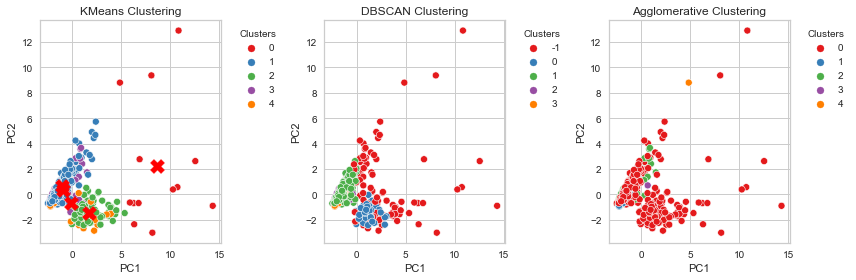

In [297]:
# Assigning the cluster labels back to pca_data
pca_data['KMeans_Labels'] = kmeans_labels_pca
pca_data['DBSCAN_Labels'] = dbscan_labels_pca
pca_data['Agglomerative_Labels'] = agglomerative_labels_pca

# Visualizing KMeans clusters
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(x=pca_data['PC1'], y=pca_data['PC2'], hue='KMeans_Labels', data=pca_data, palette='Set1', legend='full')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='red', s=200)
plt.title('KMeans Clustering')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

# Visualizing DBSCAN clusters
plt.subplot(1, 3, 2)
sns.scatterplot(x=pca_data['PC1'], y=pca_data['PC2'], hue='DBSCAN_Labels', data=pca_data, palette='Set1', legend='full')
plt.title('DBSCAN Clustering')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

# Visualizing Agglomerative Clustering
plt.subplot(1, 3, 3)
sns.scatterplot(x=pca_data['PC1'], y=pca_data['PC2'], hue='Agglomerative_Labels', data=pca_data, palette='Set1', legend='full')
plt.title('Agglomerative Clustering')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

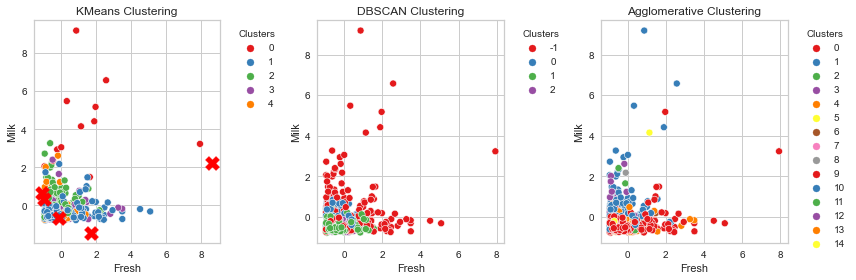

In [298]:
# Assigning cluster labels back to scaled_input_data
scaled_input_data['KMeans_Labels'] = kmeans_labels
scaled_input_data['DBSCAN_Labels'] = dbscan_labels
scaled_input_data['Agglomerative_Labels'] = agglomerative_labels

# Visualizing KMeans clusters
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(x=scaled_input_data['Fresh'], y=scaled_input_data['Milk'], hue='KMeans_Labels', data=scaled_input_data, palette='Set1', legend='full')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='red', s=200)
plt.title('KMeans Clustering')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

# Visualizing DBSCAN clusters
plt.subplot(1, 3, 2)
sns.scatterplot(x=scaled_input_data['Fresh'], y=scaled_input_data['Milk'], hue='DBSCAN_Labels', data=scaled_input_data, palette='Set1', legend='full')
plt.title('DBSCAN Clustering')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

# Visualizing Agglomerative Clustering
plt.subplot(1, 3, 3)
sns.scatterplot(x=scaled_input_data['Fresh'], y=scaled_input_data['Milk'], hue='Agglomerative_Labels', data=scaled_input_data, palette='Set1', legend='full')
plt.title('Agglomerative Clustering')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualizing results for clusters - to draw conclusions

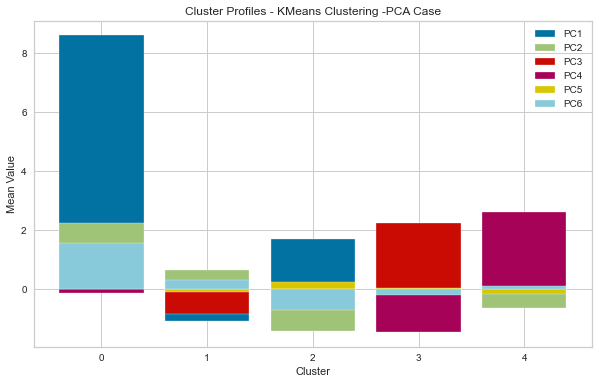

,PC1,PC2,PC3,PC4,PC5,PC6,KMeans_Labels,DBSCAN_Labels,Agglomerative_Labels
0,1.041586,-1.228494,-1.010618,-0.016948,0.167348,-1.228817,2,0,0
1,1.148801,-1.334335,-0.962797,0.020039,0.592151,-0.954102,2,0,0
2,1.563434,-0.556628,-0.970214,0.065699,2.096748,-1.069322,2,-1,0
3,-1.030662,0.999477,-0.782241,0.123379,0.178419,0.171731,1,1,0
4,1.553160,0.194343,-0.965904,0.188799,0.756596,-1.906899,2,-1,0
...,...,...,...,...,...,...,...,...,...
435,1.769822,3.108744,-0.541540,0.169563,-0.432646,0.258282,1,-1,0
436,-0.270975,2.371076,-0.840371,0.078080,-1.111064,-0.822530,1,-1,0
437,4.482935,-1.248676,-0.730491,-0.330418,-0.773928,0.501767,2,-1,0
438,-1.491373,0.293537,-0.901453,-0.071128,0.167718,0.316729,1,1,0


In [299]:
# Calculating mean feature values for each cluster
cluster_profiles_pca = pca_data.groupby('KMeans_Labels').mean()
cluster_profiles_pca=cluster_profiles_pca.drop(['Agglomerative_Labels', "DBSCAN_Labels"], axis=1)
# Visualizing cluster profiles using bar plots
plt.figure(figsize=(10, 6))
for column in cluster_profiles_pca.columns:
    plt.bar(cluster_profiles_pca.index, cluster_profiles_pca[column], label=column)

plt.xlabel('Cluster')
plt.ylabel('Mean Value')
plt.title('Cluster Profiles - KMeans Clustering -PCA Case')
plt.legend()
plt.show()
pca_data

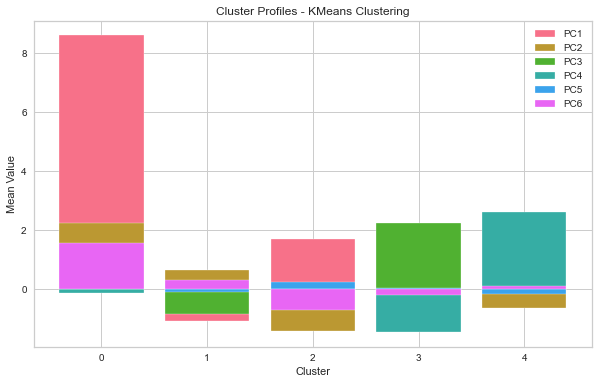

In [300]:
colors = sns.color_palette('husl', n_colors=len(cluster_profiles_pca.columns))

# Visualize cluster profiles using bar plots
plt.figure(figsize=(10, 6))
for i, column in enumerate(cluster_profiles_pca.columns):
    plt.bar(cluster_profiles_pca.index, cluster_profiles_pca[column], color=colors[i], label=column)

plt.xlabel('Cluster')
plt.ylabel('Mean Value')
plt.title('Cluster Profiles - KMeans Clustering')
plt.legend()
plt.show()

# Creating dendograms to compare with clust6ers of KMEANS

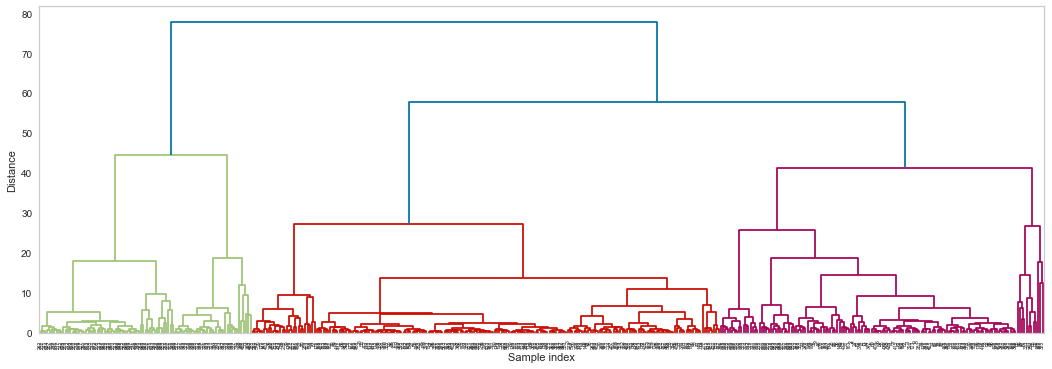

In [301]:
# Appling hierarchical clustering on the scaled_input_data and draw a dendrogram 
Z = linkage(scaled_input_data, method='ward', metric='euclidean')

# Drawing the dendrogram
plt.figure(figsize=(18,6))
dendrogram(Z)
plt.ylabel('Distance')
plt.xlabel('Sample index')
plt.grid(False)
plt.show()

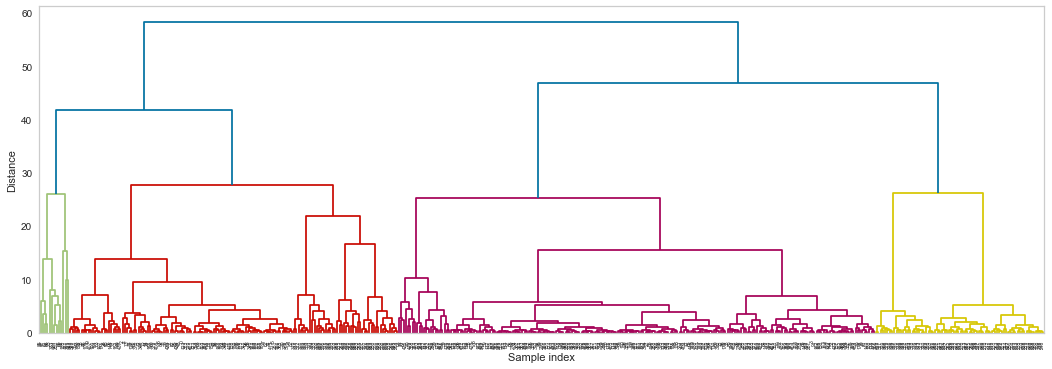

In [302]:
# Applying hierarchical clustering on the pca_data and draw a dendrogram 
Z = linkage(pca_data, method='ward', metric='euclidean')

# Drawing the dendrogram
plt.figure(figsize=(18,6))
dendrogram(Z)
plt.ylabel('Distance')
plt.xlabel('Sample index')
plt.grid(False)
plt.show()

#we see here also 4 clusters 
# based though on KMEANS which yields the best results we have 5 clusters 
#nevertheless we also see good height distances (how different each cluster is between them) and similarly good distances on the
#horizontal lines suggesting small (good) distances between each point/sample withing each cluster
#Fianlly, 4 and 5 clusters are not that different so we know that we are working under correct assumption

# Visualizing results

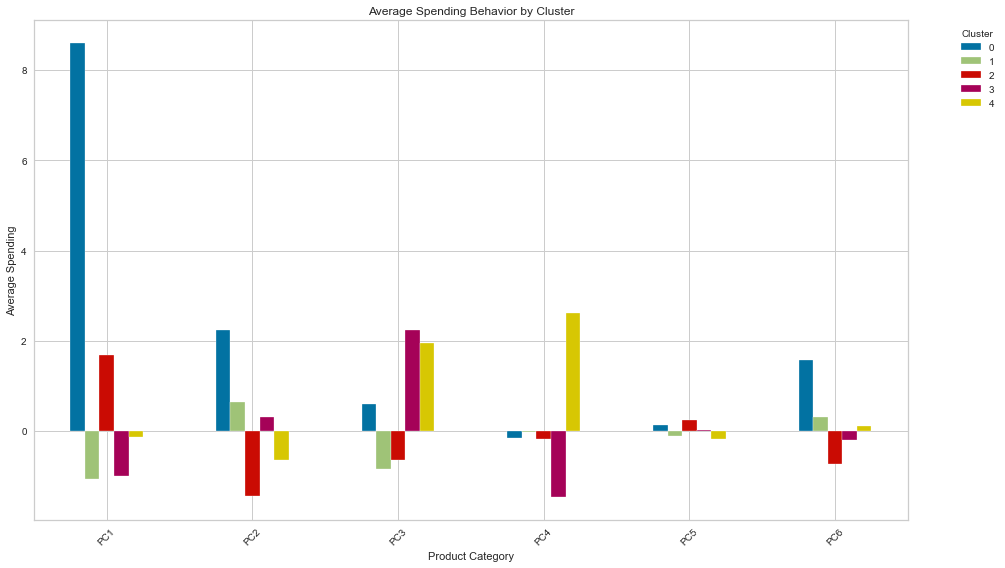

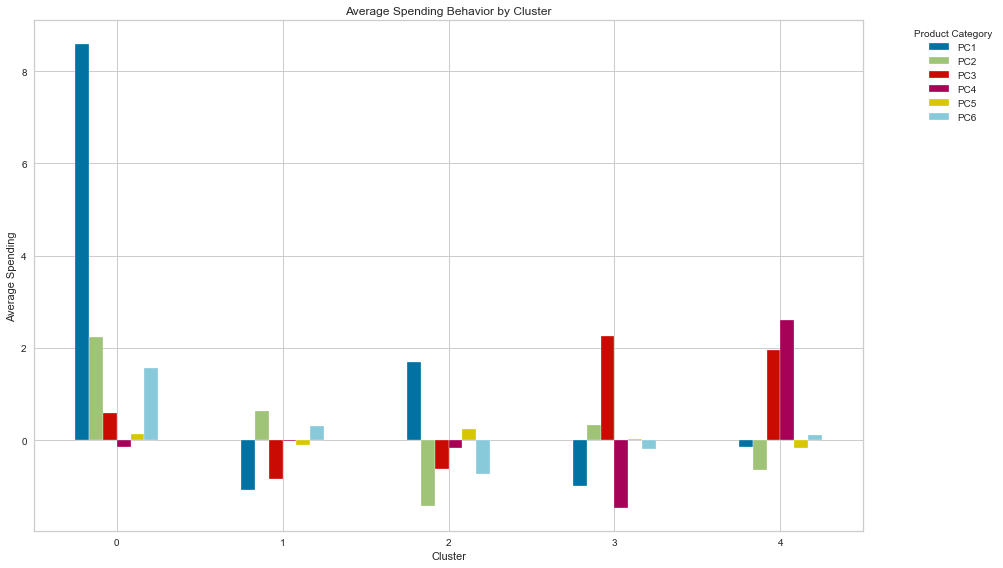

In [303]:
#DO FOR 5 CLUSTERS for PCA
cluster_means = pca_data.groupby('KMeans_Labels').mean()

cluster_means=cluster_means.drop(['Agglomerative_Labels', "DBSCAN_Labels"], axis=1)

plt.figure(figsize=(14, 8))
cluster_means.T.plot(kind='bar', ax=plt.gca())  # Use current axes
plt.title('Average Spending Behavior by Cluster')
plt.xlabel('Product Category')
plt.ylabel('Average Spending')
plt.xticks(rotation=45)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 8))

cluster_means.plot(kind='bar', ax=plt.gca())  # Use current axes
plt.title('Average Spending Behavior by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Spending')
plt.xticks(rotation=0)  # Rotate x-labels if needed
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

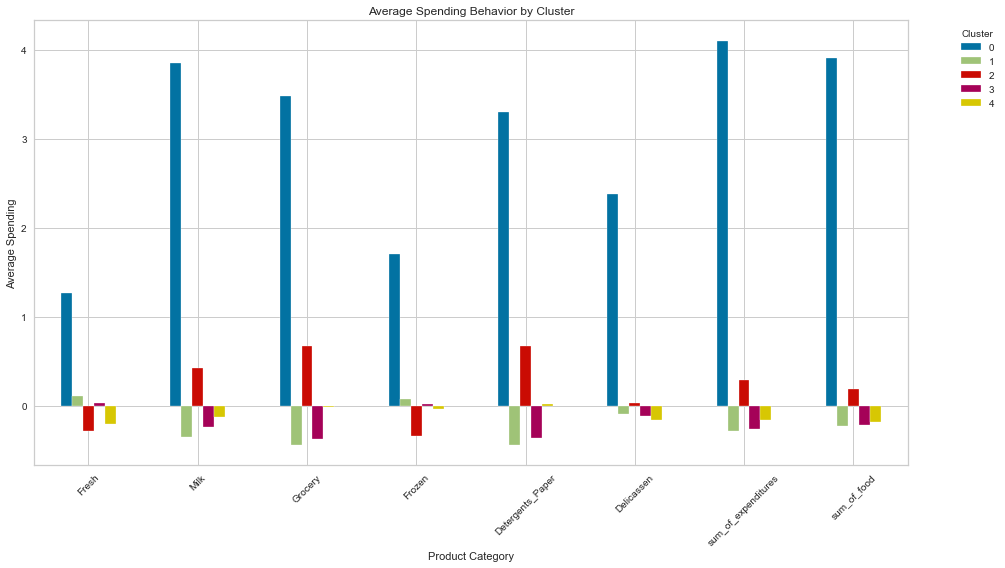

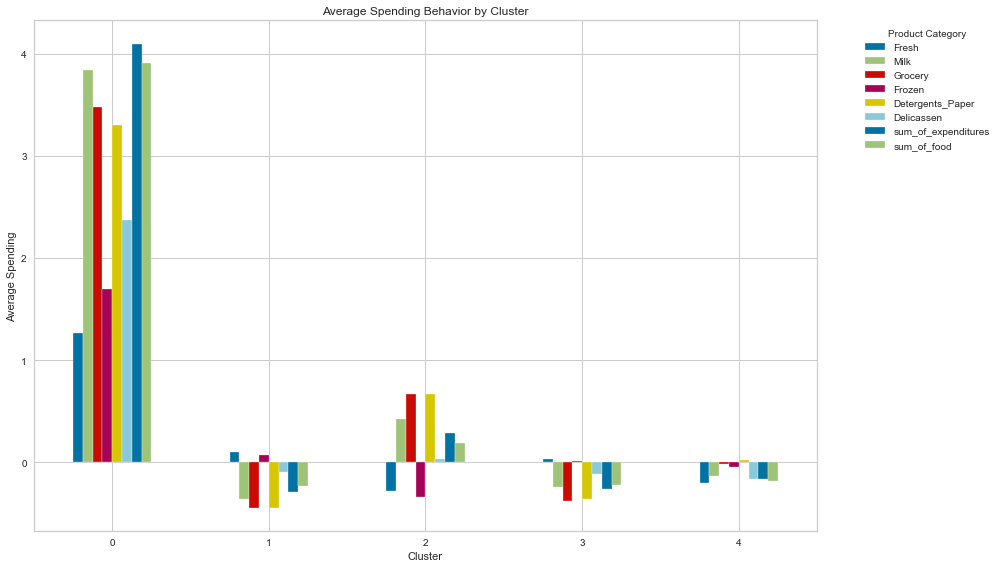

In [304]:
#DO FOR 5 CLUSTERS for NON PCA
#and compare with PCA to draw insights of our clusters
cluster_means = scaled_input_data.groupby('KMeans_Labels').mean()

cluster_means=cluster_means.drop(['Agglomerative_Labels', "DBSCAN_Labels","Channel_Horeca","Channel_Retail","Region_Porto","Region_Lisbon","Region_Other Region"], axis=1)

plt.figure(figsize=(14, 8))
cluster_means.T.plot(kind='bar', ax=plt.gca())  # Use current axes
plt.title('Average Spending Behavior by Cluster')
plt.xlabel('Product Category')
plt.ylabel('Average Spending')
plt.xticks(rotation=45)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 8))

cluster_means.plot(kind='bar', ax=plt.gca())  # Use current axes
plt.title('Average Spending Behavior by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Spending')
plt.xticks(rotation=0)  # Rotate x-labels if needed
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [305]:
pca_data

,PC1,PC2,PC3,PC4,PC5,PC6,KMeans_Labels,DBSCAN_Labels,Agglomerative_Labels
0,1.041586,-1.228494,-1.010618,-0.016948,0.167348,-1.228817,2,0,0
1,1.148801,-1.334335,-0.962797,0.020039,0.592151,-0.954102,2,0,0
2,1.563434,-0.556628,-0.970214,0.065699,2.096748,-1.069322,2,-1,0
3,-1.030662,0.999477,-0.782241,0.123379,0.178419,0.171731,1,1,0
4,1.553160,0.194343,-0.965904,0.188799,0.756596,-1.906899,2,-1,0
...,...,...,...,...,...,...,...,...,...
435,1.769822,3.108744,-0.541540,0.169563,-0.432646,0.258282,1,-1,0
436,-0.270975,2.371076,-0.840371,0.078080,-1.111064,-0.822530,1,-1,0
437,4.482935,-1.248676,-0.730491,-0.330418,-0.773928,0.501767,2,-1,0
438,-1.491373,0.293537,-0.901453,-0.071128,0.167718,0.316729,1,1,0


In [306]:
scaled_input_data

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,sum_of_expenditures,sum_of_food,Channel_Horeca,Channel_Retail,Region_Lisbon,Region_Other Region,Region_Porto,KMeans_Labels,DBSCAN_Labels,Agglomerative_Labels
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339,0.033649,0.046335,-1.448652,1.448652,-0.460566,0.626422,-0.345822,2,0,1
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151,0.001514,-0.015750,-1.448652,1.448652,-0.460566,0.626422,-0.345822,2,0,1
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293,0.128535,0.116514,-1.448652,1.448652,-0.460566,0.626422,-0.345822,2,-1,1
3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411,-0.222026,-0.147081,0.690297,-0.690297,-0.460566,0.626422,-0.345822,1,1,0
4,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347,0.489011,0.592384,-1.448652,1.448652,-0.460566,0.626422,-0.345822,2,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,1.401312,0.848446,0.850760,2.075222,-0.566831,0.241091,1.522273,1.812763,0.690297,-0.690297,-0.460566,0.626422,-0.345822,1,-1,0
436,2.155293,-0.592142,-0.757165,0.296561,-0.585519,0.291501,0.575312,0.760034,0.690297,-0.690297,-0.460566,0.626422,-0.345822,1,-1,0
437,0.200326,1.314671,2.348386,-0.543380,2.511218,0.121456,1.678200,1.365498,-1.448652,1.448652,-0.460566,0.626422,-0.345822,2,-1,1
438,-0.135384,-0.517536,-0.602514,-0.419441,-0.569770,0.213046,-0.584667,-0.537304,0.690297,-0.690297,-0.460566,0.626422,-0.345822,1,1,0


# Finding importance of features for PCs

In [307]:
#here we work only with the PCA results
# but in order to draw some conclusions we are examining how important each feature from the original features (before pca) 
#are for each of our PCs

feature_names = scaled_input_data.drop(["KMeans_Labels","DBSCAN_Labels","Agglomerative_Labels"], axis=1).columns

# This is a daataframe to store the components and their corresponding features
components_df = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(6)], index=feature_names)

# Display the DataFrame
components_df


,PC1,PC2,PC3,PC4,PC5,PC6
Fresh,0.117670,0.453469,-0.023502,0.010290,-0.534459,-0.429923
Milk,0.384800,0.017464,0.009941,-0.092805,0.119572,0.288786
Grocery,0.399635,-0.154410,0.039267,-0.045894,-0.104913,0.314345
Frozen,0.080138,0.433381,0.085508,0.181930,0.338902,-0.090833
Detergents_Paper,0.368853,-0.238208,0.040641,-0.045103,-0.161165,0.321821
Delicassen,0.195888,0.305077,-0.008994,0.002133,0.682854,-0.018338
sum_of_expenditures,0.410759,0.236195,0.027804,-0.012018,-0.154476,0.027431
sum_of_food,0.383829,0.311593,0.022818,-0.004305,-0.139818,-0.034348
Channel_Horeca,-0.299700,0.369949,0.041378,-0.056059,-0.127394,0.497564
Channel_Retail,0.299700,-0.369949,-0.041378,0.056059,0.127394,-0.497564


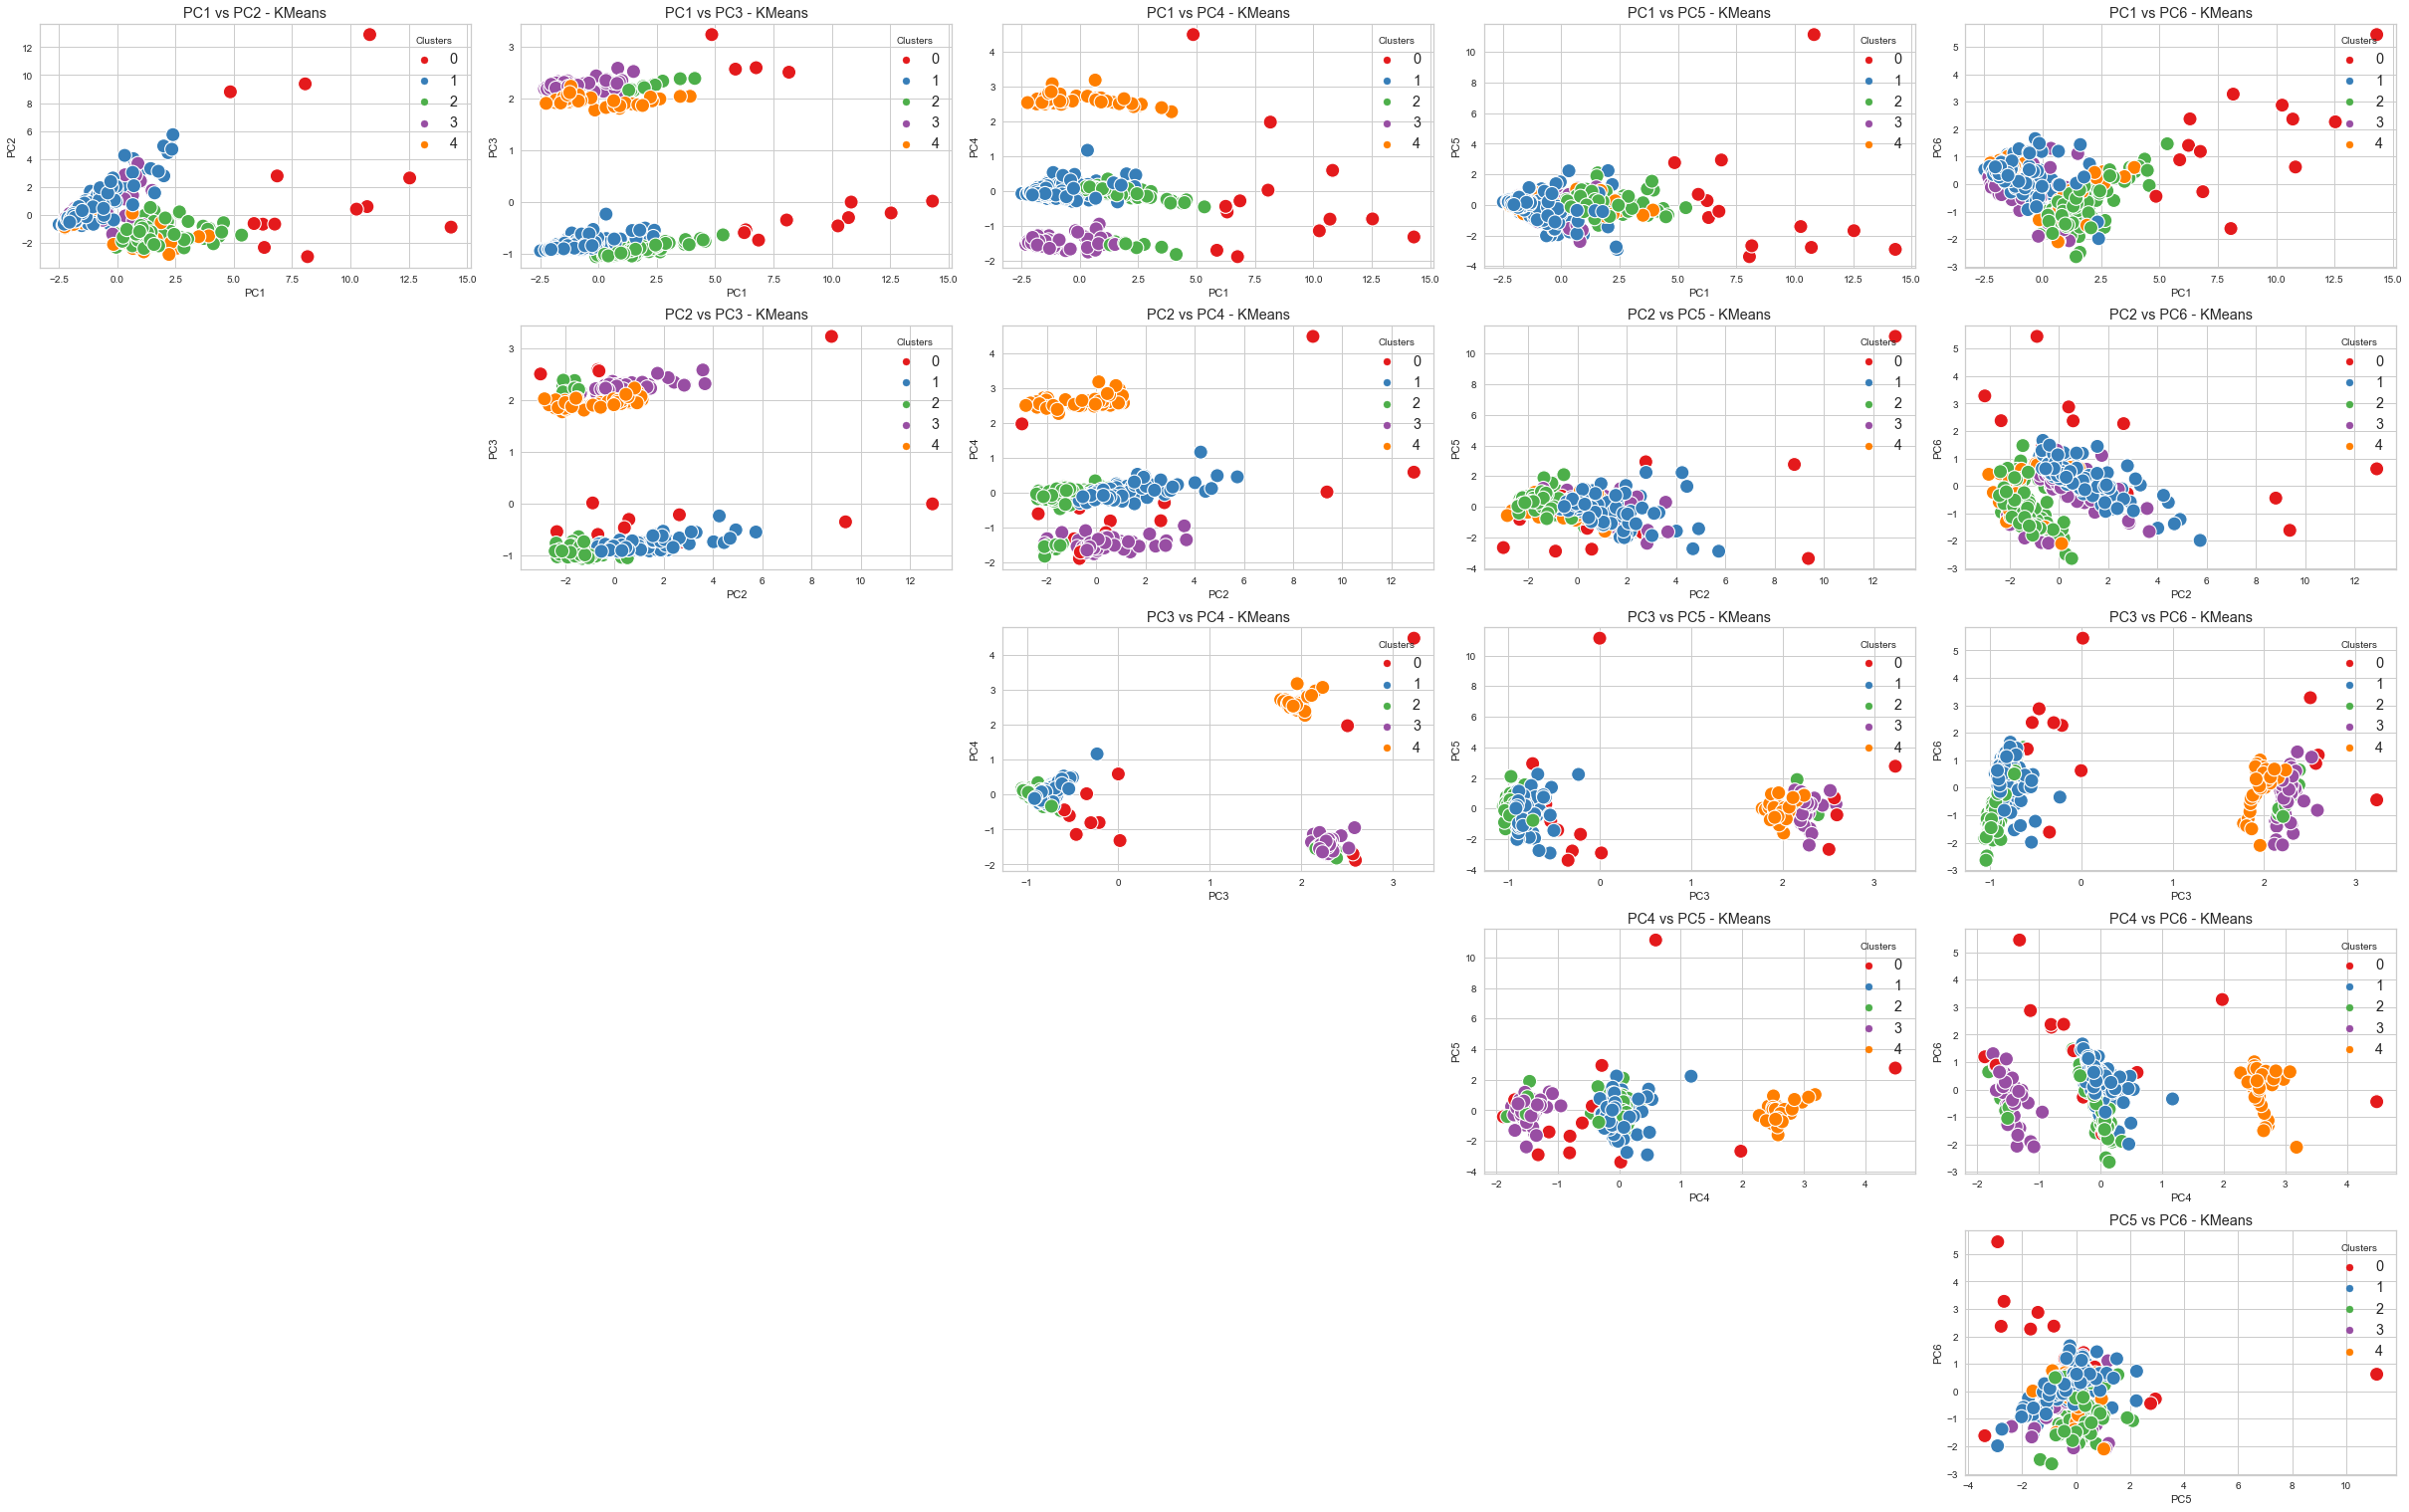

In [308]:
plt.figure(figsize=(40, 25))

for i in range(1, 7):
    for j in range(i + 1, 7):
        plt.subplot(6, 6, ((i-1)*6) + (j-1) + 1)  #  subplot grid
        sns.scatterplot(x=pca_data[f'PC{i}'], y=pca_data[f'PC{j}'], hue=kmeans_labels_pca, palette='Set1', s=200)
        plt.legend(title='Clusters', loc='upper right', fontsize='x-large')
        plt.title(f'PC{i} vs PC{j} - KMeans', fontsize='x-large')

plt.tight_layout()
plt.show()

In [309]:
# Calculating the absolute values of the components
components_abs = components_df.abs()

# Sum of the absolute values across all principal components
components_abs_sum = components_abs.sum(axis=1)

# Sorting the features based on their importance (sum of absolute values across components)
sorted_features = components_abs_sum.sort_values(ascending=False)

# Displaying the sorted features
pd.DataFrame(sorted_features)



,0
Fresh,1.569313
Channel_Retail,1.392044
Channel_Horeca,1.392044
Region_Porto,1.373393
Region_Lisbon,1.345439
Delicassen,1.213283
Frozen,1.210692
Detergents_Paper,1.175790
Grocery,1.058465
Milk,0.913368


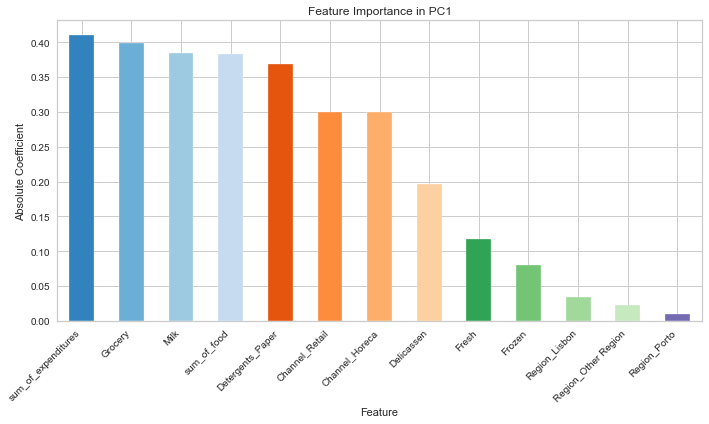

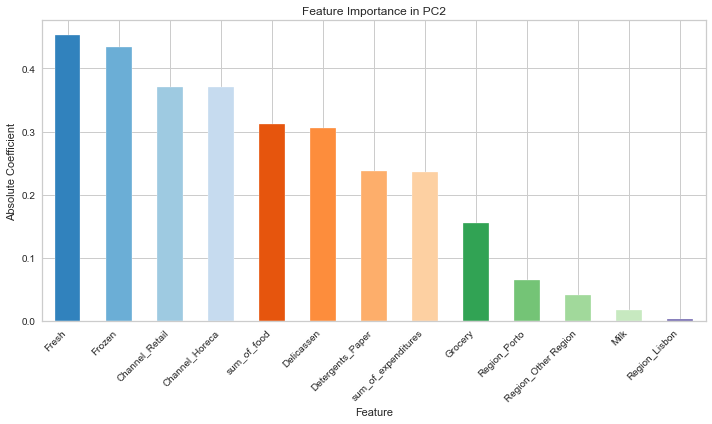

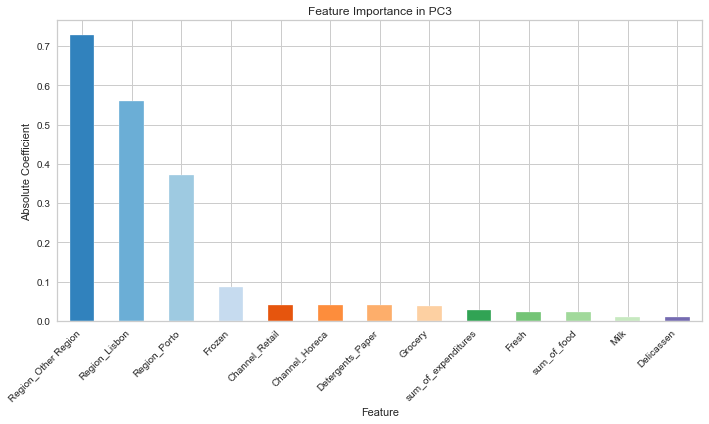

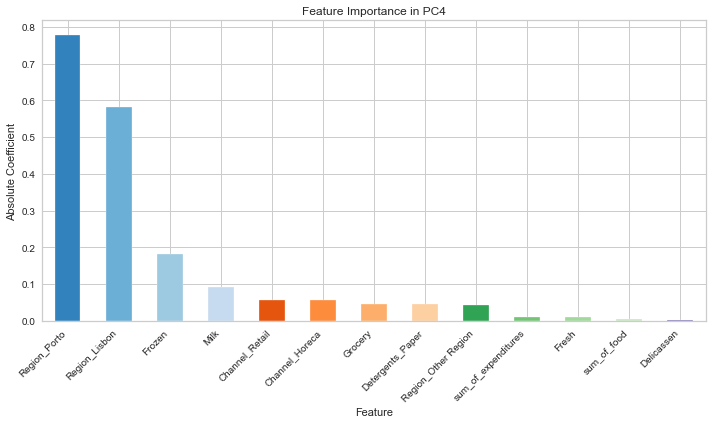

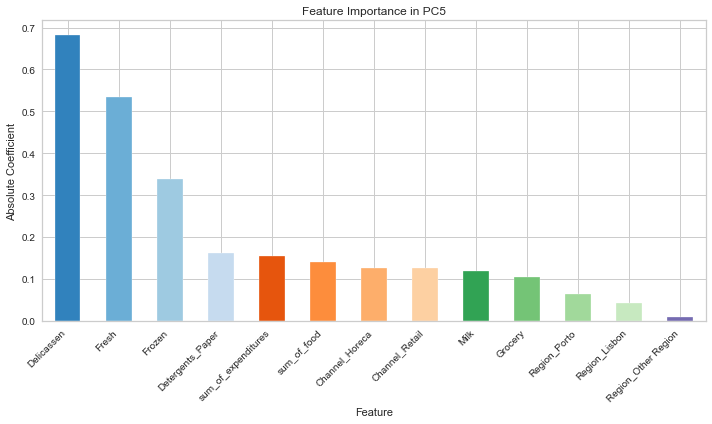

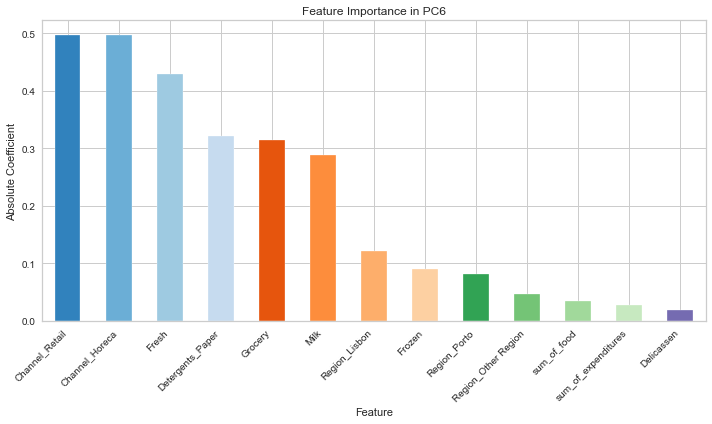

In [310]:
colors = plt.cm.tab20c(range(len(sorted_features_pc1)))

# Plotting sorted features for PC1
plt.figure(figsize=(10, 6))
sorted_features_pc1.plot(kind='bar', color=colors)
plt.title('Feature Importance in PC1')
plt.xlabel('Feature')
plt.ylabel('Absolute Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Repeating for PC2 to PC6
for i in range(2, 7):
    sorted_features_pc = components_df[f'PC{i}'].abs().sort_values(ascending=False)
    colors = plt.cm.tab20c(range(len(sorted_features_pc)))
    
    plt.figure(figsize=(10, 6))
    sorted_features_pc.plot(kind='bar', color=colors)
    plt.title(f'Feature Importance in PC{i}')
    plt.xlabel('Feature')
    plt.ylabel('Absolute Coefficient')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

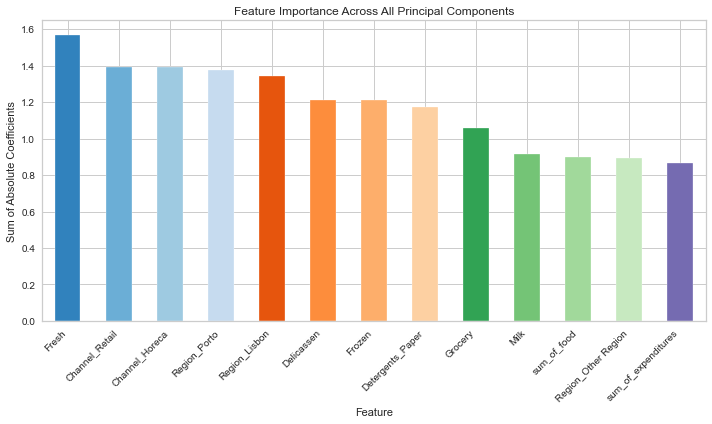

In [311]:
#PLotting the summ of absilute coefficeient and the feature importance for ALL PC
colors =  plt.cm.tab20c(range(len(sorted_features)))

# Plot the sorted features with different colors for each column
plt.figure(figsize=(10, 6))
sorted_features.plot(kind='bar', color=colors)
plt.title('Feature Importance Across All Principal Components')
plt.xlabel('Feature')
plt.ylabel('Sum of Absolute Coefficients')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


pca_data

In [312]:
# numbre of points per cluster
for label in np.unique(kmeans_labels_pca):
    mask = kmeans_labels_pca == label
    print(f"Number of points in Cluster {label}: {np.sum(mask)}")


Number of points in Cluster 0: 13
Number of points in Cluster 1: 209
Number of points in Cluster 2: 108
Number of points in Cluster 3: 65
Number of points in Cluster 4: 45


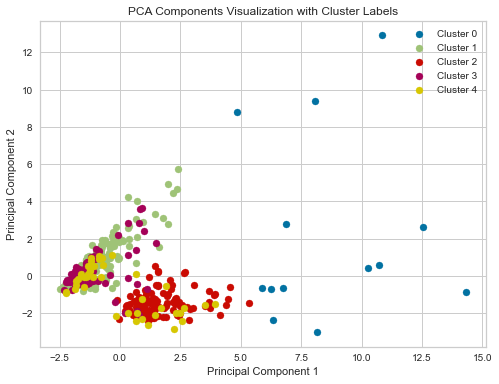

In [313]:
pca_with_clusters = pca_data.drop(["DBSCAN_Labels","Agglomerative_Labels"], axis=1)  # Create a copy of PCA results DataFrame

plt.figure(figsize=(8, 6))

# Iterate over unique cluster labels
for label in np.unique(pca_with_clusters['KMeans_Labels']):
    mask = pca_with_clusters['KMeans_Labels'] == label
    plt.scatter(pca_with_clusters.loc[mask, 'PC1'], pca_with_clusters.loc[mask, 'PC2'], label=f'Cluster {label}')

plt.title('PCA Components Visualization with Cluster Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Samples contribution to PCs

Shape of scaled_input_data: (440, 13)
Shape of loadings: (13, 6)


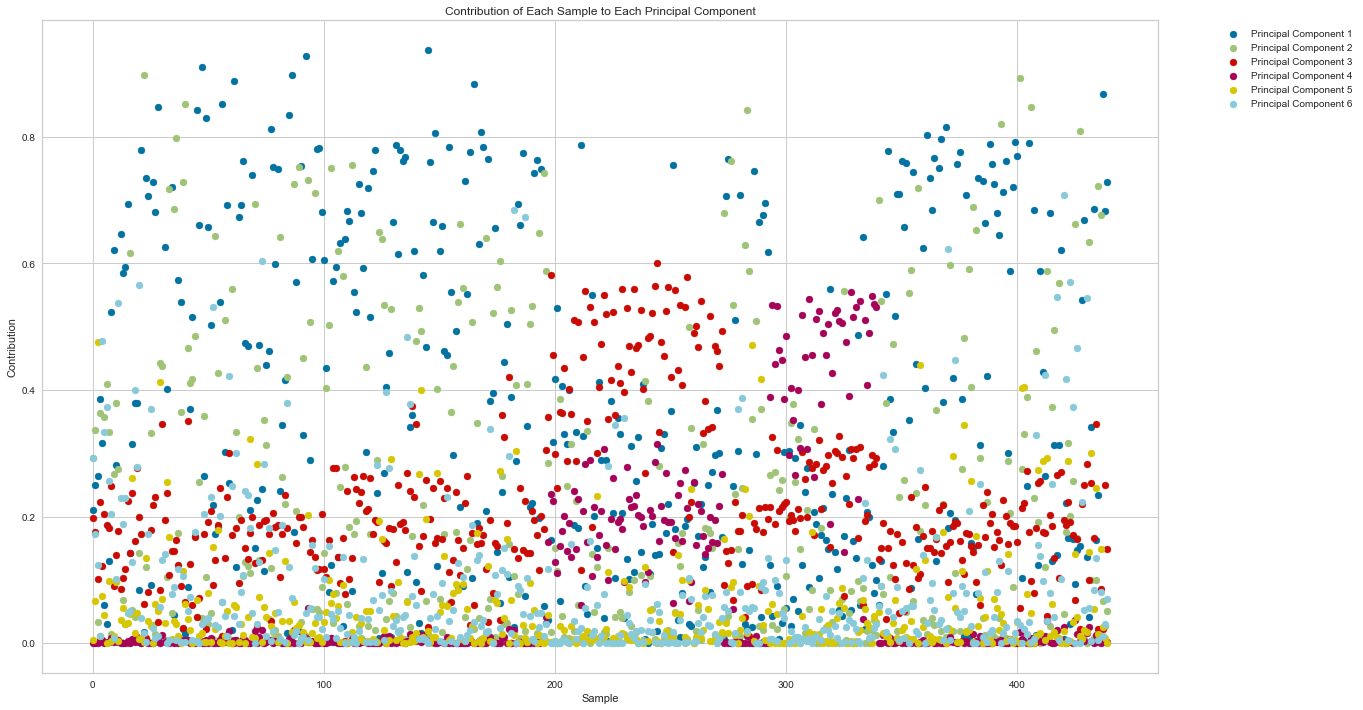

In [314]:
#Effort to identify how each sample of our data set is contributing to each one of our principal components 

loadings = pca.components_.T  # Transpose to get loadings
scaled_input_data_no_labels=scaled_input_data.drop(["KMeans_Labels","DBSCAN_Labels","Agglomerative_Labels"], axis=1)
# Verifing dimensions/shapes
print("Shape of scaled_input_data:", scaled_input_data_no_labels.shape)
print("Shape of loadings:", loadings.shape)

# Projecting the original data onto the principal components
projected_data = np.dot(scaled_input_data_no_labels - pca.mean_, loadings)

# Calculating the contributions of each sample to each principal component
contributions = projected_data ** 2  # Squaring the values (remove negatives)

# Normalizing  contributions
contributions /= np.sum(contributions, axis=1, keepdims=True)


num_components = contributions.shape[1]

plt.figure(figsize=(20, 12))
for i in range(num_components):
    plt.scatter(range(len(contributions)), contributions[:, i], label=f'Principal Component {i+1}')

plt.title('Contribution of Each Sample to Each Principal Component')
plt.xlabel('Sample')
plt.ylabel('Contribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()